In [2]:
# https://stackoverflow.com/questions/38848219/center-align-outputs-in-ipython-notebook
from IPython.display import display, HTML

# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
# display(HTML("<style>.container { width:100% !important; }</style>"))
# HTML('<style>{}</style>'.format(CSS))

display(HTML(data="""
<style>
    div#notebook-container    { width: 70%; }
    div#menubar-container     { width: 70%; }
    div#maintoolbar-container { width: 99%; }
    .output{
    align-items: center!important;
    }
    .output_subarea{
    max-width: 90%!important;
    }
</style>
"""))

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from scipy import stats
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16,10)
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 22}

rc('font', **font)
# plt.style.available

# Weather in Z&uuml;rich (Fluntern Station)
## Federal Office of Meteorology and Climatology MeteoSwiss
#### Altitude: 556 m, Coordinates 47<sup>o</sup> 22.7' N / 8<sup>o</sup> 33.9' E

| Measurement | Reference date <br>of homogenization | Last inhomgeneity <br>provisionally corrected | Units
| ---: | :---: | :---: | :--- |
|Temperature | 01.12.2009 | yes| Celcius
|Precipitaton| 01.12.2009 | no | millimeters

In [45]:
data = pd.read_json("data/clean_zurich_weather.json")

---

## Temperature

### What is the overall trend in the temperature in ZÃ¼rich? Is the trend the same in all months, or does it vary by month?

** *What is the trend of mean temperature per year?* **

In [98]:
# data.groupby('Year').mean().reset_index().plot.bar('Year','Temperature')

In [95]:
yearly_temp_mean = data.groupby('Year').mean()['Temperature'].reset_index()

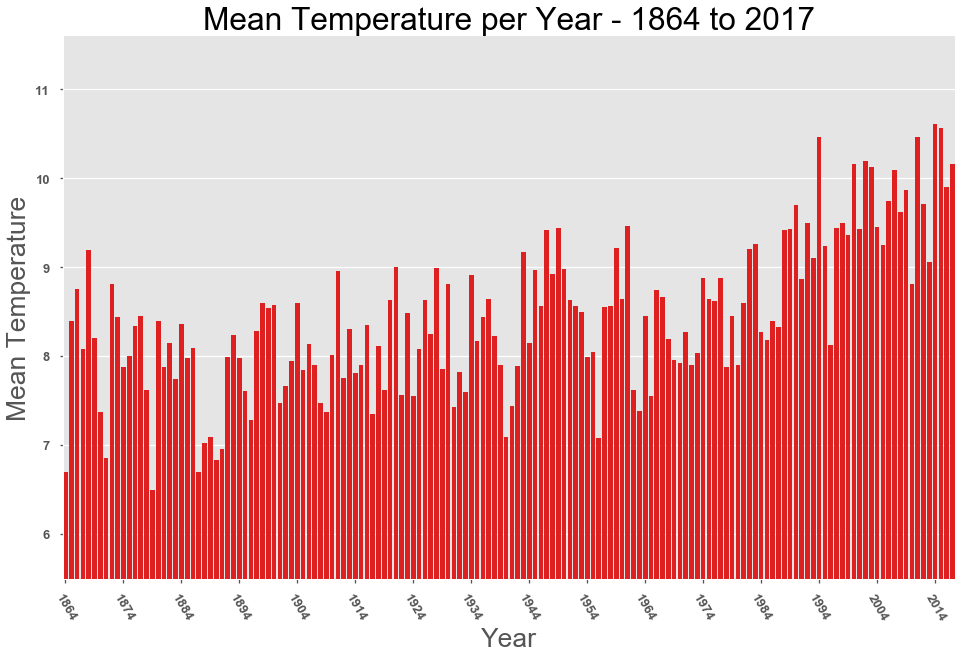

In [96]:
g = sns.barplot('Year', 'Temperature', data=mean_yearly, color='red', errcolor='orange')
locs, labels = plt.xticks()
sample = lambda arr, n: arr[::n]
plt.xticks(sample(locs, 10), sample(labels, 10), rotation=-60)
plt.ylim((min(yearly_temp_mean.Temperature)-1, max(yearly_temp_mean.Temperature)+1))
plt.ylabel("Mean Temperature")
plt.title("Mean Temperature per Year - {} to {}".format(min(yearly_temp_mean.Year), max(yearly_temp_mean.Year)))
None

** *What is the temperature trend per month and year?* **

In [97]:
temp_month_year = data.sort_values('Year').set_index(['Year','Month'])['Temperature']
monthly_temp_mean = data.groupby("Month").mean()['Temperature']
avg_temp_overall = monthly_temp_mean.mean()
yearly_sub_avg = yearly_temp_mean[yearly_temp_mean < avg_temp_overall]
yearly_above_avg = yearly_temp_mean[yearly_temp_mean > avg_temp_overall]
# temp_month_year.unstack()

In [98]:
sorted_years = sorted(data.Year.unique())

In [99]:
def _barplot(x,y,**kwargs):
    """Establish default ordering - Year, ascending - for mapping sns.barplot"""
    kwargs['order'] = sorted_years
    kwargs['color'] = 'red'
    _ = sns.barplot(x,y,**kwargs)

In [100]:
df_temp = temp_month_year.reset_index()
# I suspect that month 12 is a winter month (December), 
# so I'll move it to the front of the line for convenient grouping
df_temp = df_temp.assign(Month=df_temp.Month.apply(lambda x: 0 if x == 12 else x))

In [111]:
df_temp = df_temp.assign(mean_year = df_temp.Year.apply(lambda x: 
                                                       yearly_temp_mean[yearly_temp_mean.Year == x]\
                                                        .Temperature.values[0]))

In [126]:
df_temp = df_temp.assign(mean_month = df_temp.Month.apply(lambda x:
                                                          monthly_temp_mean.iloc[int(x)]))

In [133]:
df_temp = df_temp.assign(diff_month = [x.Temperature - x.mean_month for _,x in df_temp.iterrows()])

In [132]:
df_temp = df_temp.assign(diff_year = [x.Temperature - x.mean_year for _,x in df_temp.iterrows()])

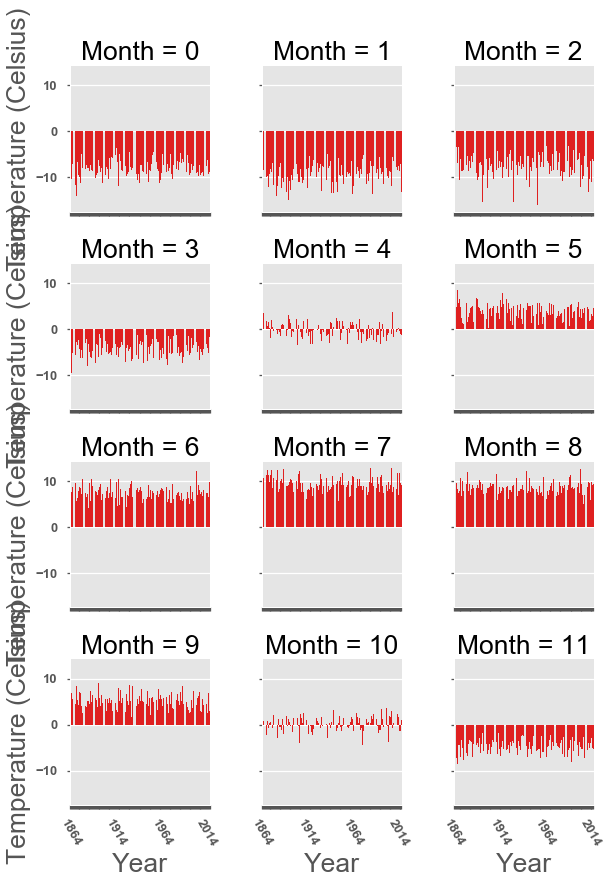

In [134]:
g = sns.FacetGrid(data = df_temp, col='Month', col_wrap=3, height=3)
g = g.map(_barplot, 'Year', 'diff_year')

g.set_ylabels("Temperature (Celsius)")
g.set_xlabels("Year")

# https://github.com/mwaskom/seaborn/issues/867#issuecomment-186404364
n = 50
for ax in g.axes.flat:
    ax.set_xticklabels([year if i%n == 0 else "" for i, year in enumerate(sorted_years)])
    for label in ax.get_xticklabels():
        label.set_rotation(-60)
        
None

### Were there multi-year periods in the past that were warmer or colder than the long-term avg? How long were they?

In [14]:
print(\
"Between {} and {}: \n\nThere were {} years with lower than \
average yearly mean temperatures \nand {} years with higher \
than average yearly temperatures."\
      .format(min(data.Year), max(data.Year), len(yearly_sub_avg), len(yearly_above_avg)))

Between 1864 and 2017: 

There were 82 years with lower than average yearly mean temperatures 
and 72 years with higher than average yearly temperatures.


In [15]:
def get_index_intervals(data, interval_length):
    """ Gather set of interval where, within the interval, there is a difference of 'interval_length' between indexes """
    count = 0
    intervals = []
    interval = []
    for i in range(len(data)-1):
        diff = data.index[i+1] - data.index[i]
        if diff == interval_length:
            count += 1
            interval.append(i)
        else:
            if len(interval) > 0:
                intervals.append(interval)
            interval = []
    
    if len(interval) > 0:
        intervals.append(interval)
    return intervals

In [16]:
sub_temp_intervals = get_index_intervals(yearly_sub_avg, 1)

In [17]:
above_temp_intervals = get_index_intervals(yearly_above_avg, 1)

In [18]:
print("There were {} periods between {} and {} where the mean \ntemperature was lower than the overall mean temperature of Zurich."\
      .format(len(sub_temp_intervals), min(data.Year), max(data.Year)))

There were 15 periods between 1864 and 2017 where the mean 
temperature was lower than the overall mean temperature of Zurich.


In [19]:
print("There were {} periods between {} and {} where the mean \ntemperature was higher than the overall mean temperature of Zurich."\
      .format(len(above_temp_intervals), min(data.Year), max(data.Year)))

There were 9 periods between 1864 and 2017 where the mean 
temperature was higher than the overall mean temperature of Zurich.


In [20]:
longest_sub_interval = sorted(sub_temp_intervals, key=lambda x: len(x), reverse=True)[0]
year1_sub = yearly_sub_avg.index[longest_sub_interval[0]]
year2_sub = yearly_sub_avg.index[longest_sub_interval[-1]]
print("The longest period of colder than average temperatures was {} years between {} and {}."\
      .format(len(longest_sub_interval), year1_sub, year2_sub))

The longest period of colder than average temperatures was 19 years between 1878 and 1896.


In [21]:
longest_above_interval = sorted(above_temp_intervals, key=lambda x: len(x), reverse=True)[0]
year1_above = yearly_above_avg.index[longest_above_interval[0]]
year2_above = yearly_above_avg.index[longest_above_interval[-1]]
print("The longest period of higher than average temperatures was {} years between {} and {}."\
      .format(len(longest_above_interval), year1_above, year2_above))

The longest period of higher than average temperatures was 20 years between 1997 and 2016.


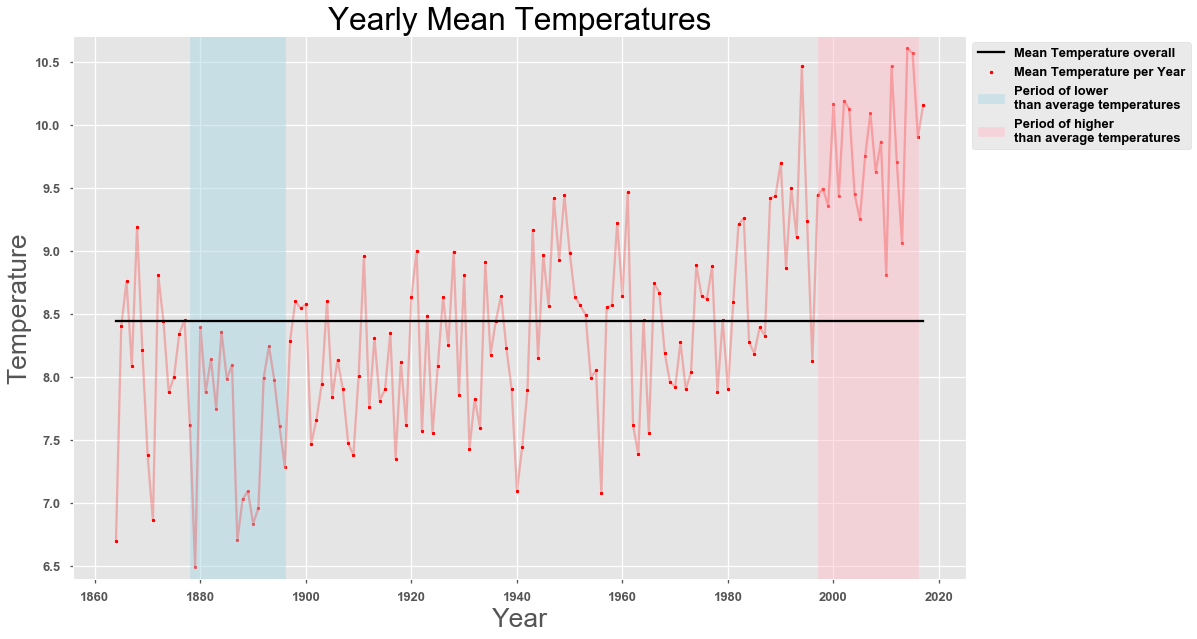

In [58]:
g = sns.lineplot("Year", "Temperature", 
                 data=yearly_temp_mean.reset_index(), 
                 color='red', 
                 alpha=0.25)
g = sns.scatterplot("Year", "Temperature",
                data=yearly_temp_mean.reset_index(),
                color='red',
                s=20,
                label="Mean Temperature per Year")
g = sns.lineplot(yearly_temp_mean.index, 
                 [avg_temp_overall for _ in yearly_temp_mean.index], 
                 color='black',
                 label="Mean Temperature overall")

plt.fill_between([year1_sub, year2_sub], *g.get_ylim(), color='lightblue', alpha=0.5, label="Period of lower \nthan average temperatures")
plt.fill_between([year1_above, year2_above], *g.get_ylim(), color='pink', alpha=0.5, label="Period of higher \nthan average temperatures")

plt.ylim((min(yearly_temp_mean)-0.1,max(yearly_temp_mean)+0.1))
plt.title("Yearly Mean Temperatures")
plt.legend(bbox_to_anchor=(1, 1))
None

### How much warmer (or cooler?) was ZÃ¼rich in Jan 2017 compared to the past?

** *What are the temperatures of all Januaries in this dataset?* **

In [23]:
january = df_temp[df_temp.Month == 1]
temp_2017 = january[january.Year == 2017]['Temperature'].values[0]
diff_jan_temp = january.Temperature.mean() - temp_2017
below_above = "below" if temp_2017 < january.Temperature.mean() else "above" 

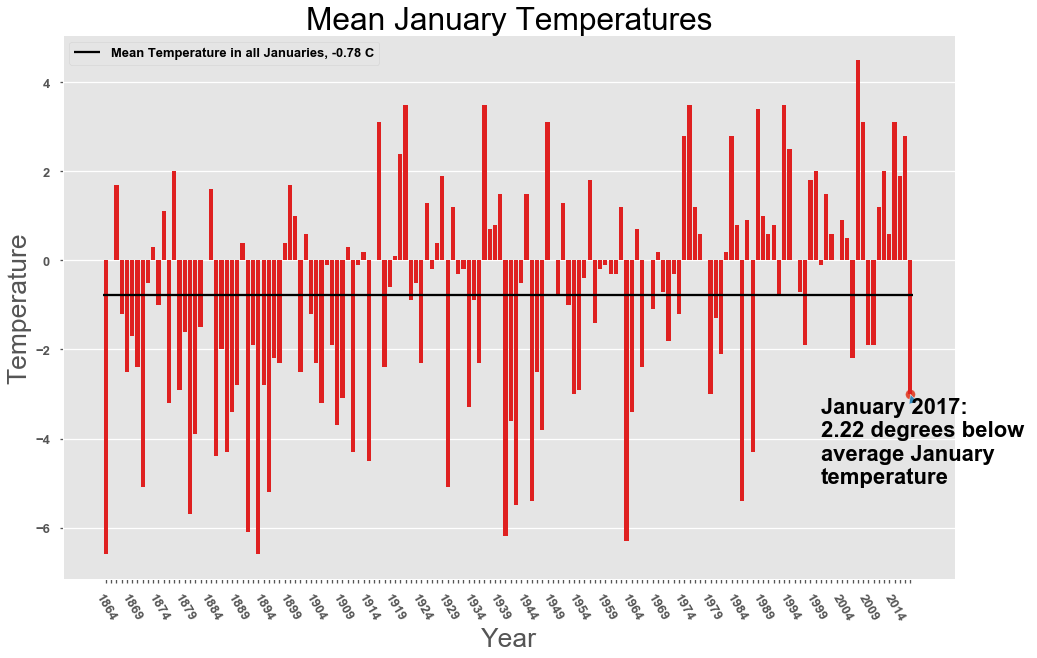

In [53]:
g = sns.barplot("Year", "Temperature", data=january, color='red')
plt.hlines(january.Temperature.mean(), *g.get_xlim(), label="Mean Temperature in all Januaries, {:.2f} C".format(january.Temperature.mean()))
plt.scatter(g.get_xticks()[-1], temp_2017)
new_ticks = [label if i%5 == 0 else "" for i, label in enumerate(g.get_xticklabels())]
g.set_xticklabels(new_ticks)
plt.xticks(rotation=-60)
g.annotate("January 2017:\n{:.2f} degrees {} \naverage January\ntemperature".format(abs(diff_jan_temp), below_above),
           xy=(g.get_xticks()[-1], temp_2017),
           xytext=(g.get_xticks()[-1]-17, temp_2017-2),
           arrowprops=({'arrowstyle':'-|>'}))

plt.title("Mean January Temperatures")
plt.legend()
None

### Were most months in 2017 warmer or cooler than the long-term average?

In [25]:
df_2017 = df_temp[df_temp.Year == 2017]
warmer_2017 = df_2017[df_2017.Temperature > avg_temp_overall]
print("There were {} months in 2017 which were warmer than average.".format(len(warmer_2017)))

There were 8 months in 2017 which were warmer than average.


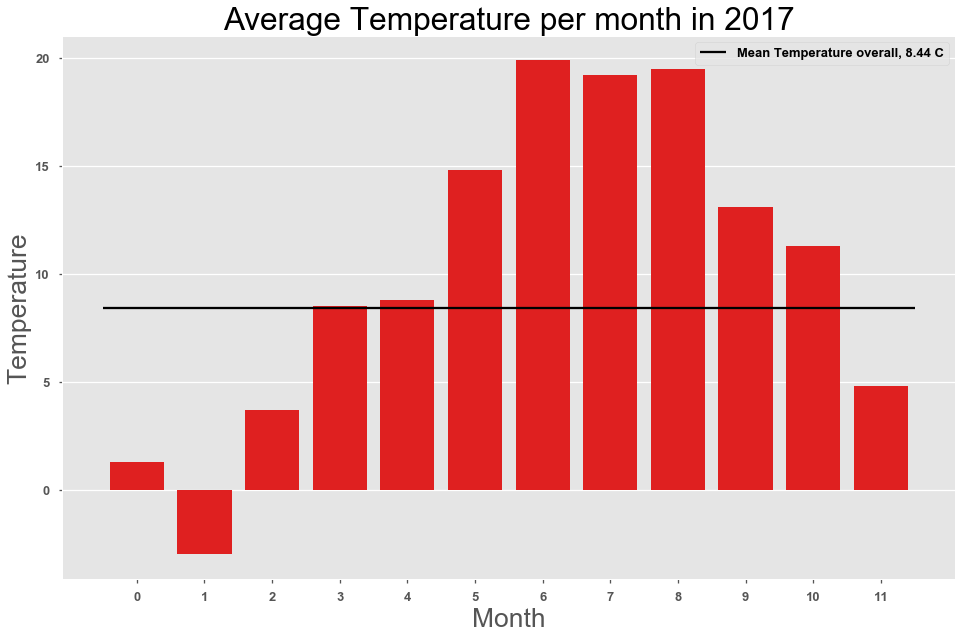

In [54]:
g = sns.barplot("Month", "Temperature", data=df_2017, color='red')
plt.hlines(avg_temp_overall, *g.get_xlim(), label="Mean Temperature overall, {:.2f} C".format(avg_temp_overall))
plt.title("Average Temperature per month in 2017")
plt.legend()
None

### What do you expect the average temp in summer 2018 to be (point or interval estimate)? Summer 2020?

## Precipitation

### How do precipitation levels compare between summer 2017 and the historical avg? Winter 2017? Spring, fall?

In [27]:
prec_month_year = data.sort_values('Year').set_index(['Year','Month'])['Precipitation'].reset_index()

In [28]:
prec_2017 = prec_month_year[prec_month_year.Year == 2017]
yearly_prec_mean = prec_month_year.groupby("Year").mean()['Precipitation']
monthly_prec_mean = prec_month_year.groupby("Month").mean()['Precipitation']
avg_prec_overall = yearly_prec_mean.mean()
avg_prec_2017 = prec_2017.mean()['Precipitation']
diff_avg_prec = avg_prec_overall - avg_prec_2017

In [29]:
print("The mean precipitation of 2017, {:.2f} mm, is {:.2f} mm {} the overall mean precipitation, {:.2f} mm."\
      .format(avg_prec_2017, abs(diff_avg_prec), "below" if diff_avg_prec > 0 else "above", avg_prec_overall))

The mean precipitation of 2017, 92.22 mm, is 3.98 mm above the overall mean precipitation, 88.24 mm.


In [577]:
# Facet grid - months 0,1,2/3,4,5/6,7,8/9,10,11

### What do you expect the average precipitation in summer 2018 to be (point or interval estimate)? Summer 2020?

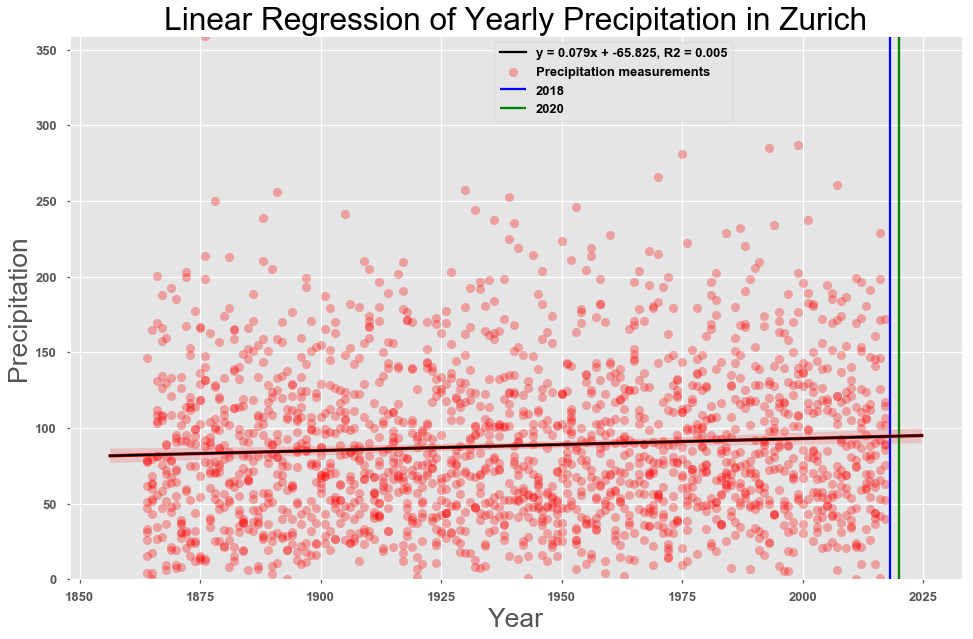

In [82]:
slope, intercept, r_value, p_value, std_err = stats.linregress(prec_month_year.Year, prec_month_year.Precipitation)
g = sns.regplot("Year", "Precipitation", data=prec_month_year, 
                color='red',
                scatter_kws={'alpha':0.3},
                label="Precipitation measurements")
x = g.get_xlim()
y = [slope * i + intercept for i in x]
g = sns.lineplot(x, y, color='black', label='y = {:.3f}x + {:.3f}, R2 = {:.3f}'.format(slope, intercept, r_value**2))

plt.vlines(2018, *g.get_ylim(), color='b', label="2018")
plt.vlines(2020, *g.get_ylim(), color='g', label="2020")

plt.ylim(min(data.Precipitation), max(data.Precipitation))
plt.legend(bbox_to_anchor=(0.75,1))
plt.title("Linear Regression of Yearly Precipitation in Zurich")
None